In [1]:
import sys
import os
import numpy as np
cwd = os.getcwd()
#Add the directory of the module to the path.
sys.path.append('/'.join(cwd.split('/')[0:-1]))
from virtualMACS import virtualMACS
import mcstasscript as ms

# Initialize the object with a clear name and a cif file

In [2]:
testobj = virtualMACS('test_experiment',cifName='TiO2.cif',useOld=False)
testobj.sample.formula_weight=79.87
#File I/O operations require sudo access. Update to your password below.
testobj.sudo_password='password'

 Material.formula_weight=(val)


## Set the sample parameters

In this example, we use a box of the same dimensions as in the reference experiment. (4.3mm  x 3.3mm x 1.3 mm) (x,y,z)

In [3]:
testobj.sample.sample_shape='box'
testobj.sample.sample_widx=4.3e-3 
testobj.sample.sample_widy=1.3e-3
testobj.sample.sample_widz=3.3e-3 


## Assign Monochromator Parameters
In this example, we use Ei=5meV = Ef

In [4]:
testobj.monochromator.Ei = 5.0
testobj.monochromator.Ef = 5.0

## Assign Kidney Parameters

In [5]:
testobj.kidney.Ef=5.0
testobj.kidney.kidney_angle=-10.0

## Checking sample orientation and projection into lab frame is correct.

In [6]:
#First need to convert CIF to lau style file. 
testobj.sample.cif2lau()
Qmod_110 = testobj.sample.Qmag_HKL(1,1,0)
print('Momentum transfer of (110) = '+'{:.2f}'.format(Qmod_110)+' Ang^-1')

 
Conversion of CIF to crystallographical LAU file successful. 
Momentum transfer of (110) = 1.93 Ang^-1


In [7]:
#Tilt the sample
print('Sample Lattice vectors')
print('')
print('a='+str(testobj.sample.a))
print('alpha='+str(testobj.sample.alpha))
print('b='+str(testobj.sample.b))
print('beta='+str(testobj.sample.beta))
print('c='+str(testobj.sample.c))
print('gamma='+str(testobj.sample.gamma))
print('')
print('Sample orientation U')
print(testobj.sample.orient_u)
testobj.sample.orient_u=[1,1,0]
testobj.sample.orient_v=[0,0,1]
print('Sample orientation v')
print(testobj.sample.orient_v)
print('')
testobj.sample.project_sample_realspace()
print('Real Space projection of lattice vectors [ax,ay,az; bx,by,bz;cx,cy,cz]')
print(testobj.sample.labframe_mat)
print('')
print('Structure factors:')
print('|F(110)|^2 = '+str(round(testobj.sample.fetch_F_HKL(1,1,0)[3],4))+' barn')
print('|F(100)|^2 = '+str(round(testobj.sample.fetch_F_HKL(1,0,0)[3],4))+' barn')
print('|F(1-10)|^2 = '+str(round(testobj.sample.fetch_F_HKL(1,-1,0)[3],4))+' barn')
print('|F(001)|^2 = '+str(round(testobj.sample.fetch_F_HKL(0,0,1)[3],4))+' barn')



Sample Lattice vectors

a=4.6001
alpha=90.0
b=4.6001
beta=90.0
c=2.9288
gamma=90.0

Sample orientation U
[1, 1, 0]
Sample orientation v
[0, 0, 1]

Real Space projection of lattice vectors [ax,ay,az; bx,by,bz;cx,cy,cz]
[[ 3.25276 -3.25276  0.     ]
 [ 3.25276  3.25276  0.     ]
 [ 0.       0.       2.9288 ]]

Structure factors:
|F(110)|^2 = 0.1782 barn
|F(100)|^2 = 0.0 barn
|F(1-10)|^2 = 0.1782 barn
|F(001)|^2 = 0.0 barn


## Check that some sample dependent cross sections are calculated correctly

In [8]:
print('sigma_abs ='+str(testobj.sample.rho_abs)+' barn/unit cell')
print('sigma_inc ='+str(testobj.sample.sigma_inc)+' barn/unit cell')

sigma_abs =12.18076 barn/unit cell
sigma_inc =2.8716 barn/unit cell


The scripting methodology requires that the scattering processes and the scattering geometries be defined seperately. Any UNION processes and geometries are allowed, see the McStas documentation for details. The respective traces are generated using McStasScript like so

In [9]:
scattering_def = ms.McStas_instr("scattering_definition",checks=False)
inc_scatter = scattering_def.add_component("inc_scatter","Incoherent_process")
inc_scatter.sigma=testobj.sample.sigma_inc
inc_scatter.unit_cell_volume = testobj.sample.cell_vol
inc_scatter.packing_factor = 1
inc_scatter.set_AT([0,0,0])

#Single crystal process. 
crystal_scatter = scattering_def.add_component("crystal_scatter","Single_crystal_process")
crystal_scatter.delta_d_d=0.005
crystal_scatter.mosaic = 30.0
#Projections of lattice vectors onto lab frame is handled by the previous helper process.
labproj = testobj.sample.labframe_mat
crystal_scatter.ax = labproj[0,0]
crystal_scatter.ay = labproj[0,1]
crystal_scatter.az = labproj[0,2]
crystal_scatter.bx = labproj[1,0]
crystal_scatter.by = labproj[1,1]
crystal_scatter.bz = labproj[1,2]
crystal_scatter.cx = labproj[2,0]
crystal_scatter.cy = labproj[2,1]
crystal_scatter.cz = labproj[2,2]
crystal_scatter.reflections='\"'+"TiO2.lau"+'\"'
crystal_scatter.barns=1
crystal_scatter.packing_factor=1
crystal_scatter.powder=0
crystal_scatter.PG=0
crystal_scatter.interact_fraction=0.8
crystal_scatter.set_AT([0,0,0])
crystal_scatter.set_ROTATED([0,0,0])

scattering = scattering_def.add_component("TiO2","Union_make_material")
scattering.process_string='"crystal_scatter,inc_scatter"'
scattering.my_absorption=testobj.sample.rho_abs
scattering.set_AT([0,0,0])

#Now, this pseudo-instrument will be saved as the scattering definition of the sample. 
testobj.sample.scattering_def = scattering_def

#Make a second object for the geometry. This particular case replicates the validation experiment for this package.
geo_def = ms.McStas_instr("geometry_definition",checks=False)

sample_cube=geo_def.add_component("sample_cube","Union_box")
sample_cube.xwidth=1.0*testobj.sample.sample_widx
sample_cube.yheight=1.0*testobj.sample.sample_widy
sample_cube.zdepth=1.0*testobj.sample.sample_widz
sample_cube.priority=100
sample_cube.material_string='\"TiO2\"'
sample_cube.number_of_activations="number_of_activations_sample" #Do not change. 
sample_cube.set_AT([0,0,0],RELATIVE='crystal_assembly')
sample_cube.set_ROTATED([0,0,0],RELATIVE='crystal_assembly')
'''
sample_cube_mask1 = geo_def.add_component("sample_cube_mask1","Union_box") #It's easier to rotate a mask rather than the sample itself.
sample_cube_mask1.xwidth=testobj.sample.sample_widx
sample_cube_mask1.yheight=testobj.sample.sample_widy
sample_cube_mask1.zdepth=testobj.sample.sample_widz
sample_cube_mask1.priority=0
sample_cube_mask1.material_string='"Mask"'
sample_cube_mask1.number_of_activations="number_of_activations_sample"
sample_cube_mask1.mask_string='"sample_cube"'
sample_cube_mask1.mask_setting='"All"'
sample_cube_mask1.visualize=0
sample_cube_mask1.set_AT([0,0,0],RELATIVE="crystal_assembly")
sample_cube_mask1.set_ROTATED([0,0,0], RELATIVE="crystal_assembly")
'''
sample_plate = geo_def.add_component("sample_plate","Union_cylinder")
sample_plate.radius=0.006
sample_plate.yheight=0.002
sample_plate.priority=40
sample_plate.material_string='"Al"'
plate_distance = testobj.sample.sample_widy+0.002
sample_plate.set_AT([0,plate_distance,0],RELATIVE="target")
sample_plate.set_ROTATED([0,0,0],RELATIVE="target")

sample_plate_rod = geo_def.add_component("sample_plate_rod","Union_cylinder")
sample_plate_rod.radius=0.00125
sample_plate_rod.yheight=0.0633
sample_plate_rod.priority=41
sample_plate_rod.material_string='"Al"'
sample_plate_rod.set_AT([0,plate_distance+0.001+0.031,0], RELATIVE="target")
sample_plate_rod.set_ROTATED([0,0,0],RELATIVE="target")

sample_base = geo_def.add_component("sample_base","Union_cylinder")
sample_base.radius=0.0065
sample_base.yheight=0.013
sample_base.priority=42
sample_base.material_string='\"Al\"'
sample_base.set_AT([0,0.0628,0],RELATIVE="target")
sample_base.set_ROTATED([0,0,0],RELATIVE="target")

sample_base_gap = geo_def.add_component("sample_base_gap","Union_cylinder")
sample_base_gap.radius=0.004
sample_base_gap.yheight=0.009
sample_base_gap.priority=43
sample_base_gap.material_string='"Vacuum"'
sample_base_gap.set_AT([0,0.0668,0], RELATIVE="target")
sample_base_gap.set_ROTATED([0,0,0],RELATIVE="target")

testobj.sample.geometry_def = geo_def


## If the instrument file has not been prepared and compiled, do so now.

In [10]:
testobj.instr_main_file

'MACS_sample_kidney.instr'

In [11]:
useOld=False
if useOld==True:
    testobj.prepare_old_expt_directory()
    #testobj.clean_expt_directory()
else:
    testobj.data.data_matrix=False
    #testobj.clean_expt_directory()
    testobj.prepare_expt_directory()
    testobj.edit_instr_file()
    testobj.compileMonochromator()

    testobj.compileInstr()


testobj.n_mono=1e7
testobj.n_sample=1e6

Generating sample parameters using file TiO2.cif
Writing instrument file assuming scattering u=[1, 1, 0], v=[0, 0, 1]
 
Instrument file /home/tjh/Github-Repos/pyMACS/pyMACS/Demonstration/test_experiment/Instrument_files/MACS_sample_kidney.instr successfully prepared.

Ready to compile.

 
]0;IPython: test_experiment/Instrument_filesThe following components are found in the work_directory / input_path:
     Union_stop.comp
These definitions will be used instead of the installed versions.
The following components are found in the work_directory / input_path:
     Union_stop.comp
These definitions will be used instead of the installed versions.
#################

Starting compilation of monochromator. This will take about around 10 minutes. 
Passing the following to bash to compile monochromator:
mcrun -c -n 10 --param=dummy_params_mono.txt --dir=mono_dummy_dir MACS_monochromator.instr


INFO: Using directory: "mono_dummy_dir"
INFO: Regenerating c-file: MACS_monochromator.c
         Move them into an INITIALIZE section. May fail at compile.
CFLAGS= -I@MCCODE_LIB@/share/ -DFUNNEL  -DFUNNEL 
INFO: Recompiling: ./MACS_monochromator.out
./MACS_monochromator.c: In function ‘write_tagging_tree’:
./MACS_monochromator.c:7829:105: warning: passing argument 4 of ‘qsort’ from incompatible pointer type [-Wincompatible-pointer-types]
 7829 |   qsort(total_history.saved_histories,total_history.used_elements,sizeof (struct saved_history_struct), Sample_compare_history_intensities);
      |                                                                                                         ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
      |                                                                                                         |
      |                                                                                                         int (*)(const struct saved_history_s

./MACS_monochromator.c: In function ‘detector_import’:
./MACS_monochromator.c:2296:57: warning: ‘ ’ directive output may be truncated writing 1 byte into a region of size between 0 and 1023 [-Wformat-truncation=]
 2296 |     snprintf(detector.variables, CHAR_BUF_LENGTH, "%s %s %s_err N", detector.xvar, c, c);
      |                                                         ^
In file included from /usr/include/stdio.h:894,
                 from ./MACS_monochromator.c:231:
/usr/include/x86_64-linux-gnu/bits/stdio2.h:71:10: note: ‘__builtin___snprintf_chk’ output 9 or more bytes (assuming 1032) into a destination of size 1024
   71 |   return __builtin___snprintf_chk (__s, __n, __USE_FORTIFY_LEVEL - 1,
      |          ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
   72 |                                    __glibc_objsize (__s), __fmt,
      |                                    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
   73 |                                    __va_arg_pack ());
      

INFO: ===
INFO: Placing instr file copy MACS_monochromator.instr in dataset mono_dummy_dir


Compilation of monochromator geometry successful.

#################

]0;IPython: test_experiment/Instrument_filesThe following components are found in the work_directory / input_path:
     Union_stop.comp
These definitions will be used instead of the installed versions.
The following components are found in the work_directory / input_path:
     Union_stop.comp
These definitions will be used instead of the installed versions.
#################

Starting compilation of sample kidney geometry. This will take a few minutes.

Passing to bash to compile sample kidney geometry:

mcrun -c -n 10 --param=dummy_params.txt --dir=dummy_kidney MACS_sample_kidney.instr


INFO: Using directory: "dummy_kidney"
INFO: Regenerating c-file: MACS_sample_kidney.c
         Move them into an INITIALIZE section. May fail at compile.
CFLAGS= -DFUNNEL  -I@MCCODE_LIB@/share/ -DFUNNEL 
INFO: Recompiling: ./MACS_sample_kidney.out
./MACS_sample_kidney.c: In function ‘write_tagging_tree’:
./MACS_sample_kidney.c:7856:105: warning: passing argument 4 of ‘qsort’ from incompatible pointer type [-Wincompatible-pointer-types]
 7856 |   qsort(total_history.saved_histories,total_history.used_elements,sizeof (struct saved_history_struct), Sample_compare_history_intensities);
      |                                                                                                         ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
      |                                                                                                         |
      |                                                                                                         int (*)(const struct saved_history_str

./MACS_sample_kidney.c: In function ‘detector_import’:
./MACS_sample_kidney.c:2296:57: warning: ‘ ’ directive output may be truncated writing 1 byte into a region of size between 0 and 1023 [-Wformat-truncation=]
 2296 |     snprintf(detector.variables, CHAR_BUF_LENGTH, "%s %s %s_err N", detector.xvar, c, c);
      |                                                         ^
In file included from /usr/include/stdio.h:894,
                 from ./MACS_sample_kidney.c:231:
/usr/include/x86_64-linux-gnu/bits/stdio2.h:71:10: note: ‘__builtin___snprintf_chk’ output 9 or more bytes (assuming 1032) into a destination of size 1024
   71 |   return __builtin___snprintf_chk (__s, __n, __USE_FORTIFY_LEVEL - 1,
      |          ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
   72 |                                    __glibc_objsize (__s), __fmt,
      |                                    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
   73 |                                    __va_arg_pack ());
      

Compilation of sample kidney geometry successful.

#################



Error: Could not open input file 'E5.00meV_HF1_VF1_Sample0.020_b1_1.00_b2_1.00_mono_mis0.15.dat' (Open_File)
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset dummy_kidney


## To clean the directory and prepare a new virtual experiment, try something like the following.

In [12]:
#The following parameters should produce a signal from the (110) on SPEC18
'''
testobj.monochromator.Ei=9.078
testobj.kidney.Ef=9.078
testobj.A3_angle = 67.37
testobj.kidney.kidney_angle=3.0
testobj.preserve_kidney_scan_files=False

testobj.runMonoScan()
testobj.runKidneyScan()
'''
#The files are saved as csv's for now, add to the data_matrix manually.
#testobj.data.load_data_matrix_from_csv('_tio2_a3scan_cube_dataMatrix.csv')


'\ntestobj.monochromator.Ei=9.078\ntestobj.kidney.Ef=9.078\ntestobj.A3_angle = 67.37\ntestobj.kidney.kidney_angle=3.0\ntestobj.preserve_kidney_scan_files=False\n\ntestobj.runMonoScan()\ntestobj.runKidneyScan()\n'


Limited MSlice-like tools are also available. To use these, first project the measurement into Q-space. Real data may also be loaded to compare to.

In [13]:

testobj.data.data_matrix


False

## Scripting is simple. Specify a set of A3 angles and a list of incident energies and the package will handle the rest.

In [14]:
testobj.n_sample=1e5
testobj.n_mono = 1e8
testobj.kidney.Ef=5.0

testobj.kidney_angle_resolution=0.8
testobj.preserve_kidney_scan_files=False
testobj.script_scan(A3_list=np.arange(-70,-20,0.25),Ei_list=[5.0],\
                    num_threads=12,scan_title='_tio2_a3scan_cube')

INFO: Using directory: "Ei_5.0_beta1_0.2704356875064211_beta2_2.4135643061615095_n_100000000.0_sample_diam_0.02"
INFO: Using existing c-file: ./MACS_monochromator.c
INFO: Using existing binary: ./MACS_monochromator.out
INFO: ===


/dev/shm/memory successfully mounted.
Running these Ei values:[5.]
37.08090288677591


Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warni

Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warni

Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warni

Total Scans:   0%|          | 0/1 [00:00<?, ?it/s]

Ei=5.0 meV:   0%|          | 0/12 [00:00<?, ?it/s]

37.08090288677591
37.08090288677591
37.08090288677591
37.08090288677591
37.08090288677591
37.08090288677591
37.08090288677591
37.08090288677591
37.08090288677591
37.08090288677591
37.08090288677591
37.08090288677591
37.08090288677591


INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m69p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m69p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m69p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m68p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./M

37.08090288677591
37.08090288677591
37.08090288677591


INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m66p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m66p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m69p0000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m66p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_k

37.08090288677591


INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m66p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m67p0000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m69p7500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m68p0000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m67p5000_sample_diameter_d_0p0200
INFO: Plac

37.08090288677591
37.08090288677591


INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m69p2500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m65p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m65p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===


37.08090288677591
37.08090288677591
37.08090288677591
37.08090288677591
37.08090288677591


INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m65p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m64p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m64p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m65p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./M

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m59p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m59p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m59p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m59p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./M

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m54p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m57p2500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m54p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m57p0000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m54p0000_sa

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m51p7500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m50p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m49p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m52p2500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m49p7500_sa

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m48p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m52p0000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m51p2500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m51p0000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m48p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m46p5000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m46p2500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m46p7500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m43p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m43p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m42p0000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m39p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m41p5000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m41p7500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m38p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m37p2500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m37p0000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m36p7500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m34p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m34p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m29p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m32p5000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m29p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m31p5000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m28p505

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m28p0000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m27p2500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m24p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m24p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m24p2500_sa

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m22p5000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m22p0000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m22p7500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m22p2500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m28p5053_Ei_5p0000_Ef_5p0000_A3_angle_m21p7500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/tes

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m25p5053_Ei_5p0000_Ef_5p0000_A3_angle_m66p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m25p5053_Ei_5p0000_Ef_5p0000_A3_angle_m65p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m25p5053_Ei_5p0000_Ef_5p0000_A3_angle_m65p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m25p5053_Ei_5p0000_Ef_5p0000_A3_angle_m65p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./M

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m25p5053_Ei_5p0000_Ef_5p0000_A3_angle_m60p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m25p5053_Ei_5p0000_Ef_5p0000_A3_angle_m63p0000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m25p5053_Ei_5p0000_Ef_5p0000_A3_angle_m60p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m25p5053_Ei_5p0000_Ef_5p0000_A3_angle_m63p2500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m25p505

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m25p5053_Ei_5p0000_Ef_5p0000_A3_angle_m58p0000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m25p5053_Ei_5p0000_Ef_5p0000_A3_angle_m58p5000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m25p5053_Ei_5p0000_Ef_5p0000_A3_angle_m55p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m25p5053_Ei_5p0000_Ef_5p0000_A3_angle_m55p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m25p5053_Ei_5p0000_Ef_5p0000_A3_angle_m55p0000_sa

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m25p5053_Ei_5p0000_Ef_5p0000_A3_angle_m50p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m25p5053_Ei_5p0000_Ef_5p0000_A3_angle_m53p2500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m25p5053_Ei_5p0000_Ef_5p0000_A3_angle_m50p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m25p5053_Ei_5p0000_Ef_5p0000_A3_angle_m53p0000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m25p5053_Ei_5p0000_Ef_5p0000_A3_angle_m50p2500_sa

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m25p5053_Ei_5p0000_Ef_5p0000_A3_angle_m48p7500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m25p5053_Ei_5p0000_Ef_5p0000_A3_angle_m45p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m25p5053_Ei_5p0000_Ef_5p0000_A3_angle_m48p5000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m25p5053_Ei_5p0000_Ef_5p0000_A3_angle_m48p2500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m25p5053_Ei_5p0000_Ef_5p0000_A3_angle_m47p7500_sample_diameter_d_0p0200
INFO: Usin

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m25p5053_Ei_5p0000_Ef_5p0000_A3_angle_m43p7500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m25p5053_Ei_5p0000_Ef_5p0000_A3_angle_m42p7500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m25p5053_Ei_5p0000_Ef_5p0000_A3_angle_m44p2500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m25p5053_Ei_5p0000_Ef_5p0000_A3_angle_m43p5000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m25p5053_Ei_5p0000_Ef_5p0000_A3_angle_m43p2500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/tes

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m25p5053_Ei_5p0000_Ef_5p0000_A3_angle_m39p2500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m25p5053_Ei_5p0000_Ef_5p0000_A3_angle_m39p0000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m25p5053_Ei_5p0000_Ef_5p0000_A3_angle_m36p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m25p5053_Ei_5p0000_Ef_5p0000_A3_angle_m36p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m25p505

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m25p5053_Ei_5p0000_Ef_5p0000_A3_angle_m31p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m25p5053_Ei_5p0000_Ef_5p0000_A3_angle_m31p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m25p5053_Ei_5p0000_Ef_5p0000_A3_angle_m34p2500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m25p5053_Ei_5p0000_Ef_5p0000_A3_angle_m31p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_k

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m25p5053_Ei_5p0000_Ef_5p0000_A3_angle_m26p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m25p5053_Ei_5p0000_Ef_5p0000_A3_angle_m28p7500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m25p5053_Ei_5p0000_Ef_5p0000_A3_angle_m29p2500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m25p5053_Ei_5p0000_Ef_5p0000_A3_angle_m26p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m25p505

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m25p5053_Ei_5p0000_Ef_5p0000_A3_angle_m25p0000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m25p5053_Ei_5p0000_Ef_5p0000_A3_angle_m21p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m25p5053_Ei_5p0000_Ef_5p0000_A3_angle_m24p0000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m25p5053_Ei_5p0000_Ef_5p0000_A3_angle_m21p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m25p5053_Ei_5p0000_Ef_5p0000_A3_angle_m21p2500_sa

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m22p5053_Ei_5p0000_Ef_5p0000_A3_angle_m69p2500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m22p5053_Ei_5p0000_Ef_5p0000_A3_angle_m69p7500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m22p5053_Ei_5p0000_Ef_5p0000_A3_angle_m70p0000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m22p5053_Ei_5p0000_Ef_5p0000_A3_angle_m68p5000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m22p5053_Ei_5p0000_Ef_5p0000_A3_angle_m66p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Usin

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m22p5053_Ei_5p0000_Ef_5p0000_A3_angle_m66p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m22p5053_Ei_5p0000_Ef_5p0000_A3_angle_m67p5000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m22p5053_Ei_5p0000_Ef_5p0000_A3_angle_m68p7500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m22p5053_Ei_5p0000_Ef_5p0000_A3_angle_m68p0000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m22p5053_Ei_5p0000_Ef_5p0000_A3_angle_m67p7500_sample_diameter_d_0p0200
INFO: Usin

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m22p5053_Ei_5p0000_Ef_5p0000_A3_angle_m61p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m22p5053_Ei_5p0000_Ef_5p0000_A3_angle_m61p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m22p5053_Ei_5p0000_Ef_5p0000_A3_angle_m61p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m22p5053_Ei_5p0000_Ef_5p0000_A3_angle_m63p7500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_k

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m22p5053_Ei_5p0000_Ef_5p0000_A3_angle_m56p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m22p5053_Ei_5p0000_Ef_5p0000_A3_angle_m56p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m22p5053_Ei_5p0000_Ef_5p0000_A3_angle_m56p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m22p5053_Ei_5p0000_Ef_5p0000_A3_angle_m58p5000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/tes

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m22p5053_Ei_5p0000_Ef_5p0000_A3_angle_m53p7500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m22p5053_Ei_5p0000_Ef_5p0000_A3_angle_m51p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m22p5053_Ei_5p0000_Ef_5p0000_A3_angle_m54p2500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m22p5053_Ei_5p0000_Ef_5p0000_A3_angle_m53p5000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m22p5053_Ei_5p0000_Ef_5p0000_A3_angle_m51p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m22p5053_Ei_5p0000_Ef_5p0000_A3_angle_m46p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m22p5053_Ei_5p0000_Ef_5p0000_A3_angle_m49p0000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m22p5053_Ei_5p0000_Ef_5p0000_A3_angle_m49p2500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m22p5053_Ei_5p0000_Ef_5p0000_A3_angle_m46p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m22p5053_Ei_5p0000_Ef_5p0000_A3_angle_m46p0000_sa

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m22p5053_Ei_5p0000_Ef_5p0000_A3_angle_m41p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m22p5053_Ei_5p0000_Ef_5p0000_A3_angle_m44p0000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m22p5053_Ei_5p0000_Ef_5p0000_A3_angle_m43p5000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m22p5053_Ei_5p0000_Ef_5p0000_A3_angle_m44p5000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m22p5053_Ei_5p0000_Ef_5p0000_A3_angle_m44p2500_sample_diameter_d_0p0200
INFO: Usin

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m22p5053_Ei_5p0000_Ef_5p0000_A3_angle_m37p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m22p5053_Ei_5p0000_Ef_5p0000_A3_angle_m36p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m22p5053_Ei_5p0000_Ef_5p0000_A3_angle_m39p5000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m22p5053_Ei_5p0000_Ef_5p0000_A3_angle_m39p2500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m22p505

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m22p5053_Ei_5p0000_Ef_5p0000_A3_angle_m32p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m22p5053_Ei_5p0000_Ef_5p0000_A3_angle_m32p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m22p5053_Ei_5p0000_Ef_5p0000_A3_angle_m34p7500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m22p5053_Ei_5p0000_Ef_5p0000_A3_angle_m34p5000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m22p5053_Ei_5p0000_Ef_5p0000_A3_angle_m31p7500_sa

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m22p5053_Ei_5p0000_Ef_5p0000_A3_angle_m29p7500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m22p5053_Ei_5p0000_Ef_5p0000_A3_angle_m27p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m22p5053_Ei_5p0000_Ef_5p0000_A3_angle_m27p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m22p5053_Ei_5p0000_Ef_5p0000_A3_angle_m30p0000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m22p5053_Ei_5p0000_Ef_5p0000_A3_angle_m27p0000_sa

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m22p5053_Ei_5p0000_Ef_5p0000_A3_angle_m25p5000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m22p5053_Ei_5p0000_Ef_5p0000_A3_angle_m22p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m22p5053_Ei_5p0000_Ef_5p0000_A3_angle_m22p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m22p5053_Ei_5p0000_Ef_5p0000_A3_angle_m24p7500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m22p505

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m19p5053_Ei_5p0000_Ef_5p0000_A3_angle_m68p5000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m19p5053_Ei_5p0000_Ef_5p0000_A3_angle_m70p0000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m19p5053_Ei_5p0000_Ef_5p0000_A3_angle_m68p7500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m19p5053_Ei_5p0000_Ef_5p0000_A3_angle_m69p0000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m19p5053_Ei_5p0000_Ef_5p0000_A3_angle_m67p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Usin

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m19p5053_Ei_5p0000_Ef_5p0000_A3_angle_m65p0000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m19p5053_Ei_5p0000_Ef_5p0000_A3_angle_m62p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m19p5053_Ei_5p0000_Ef_5p0000_A3_angle_m62p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m19p5053_Ei_5p0000_Ef_5p0000_A3_angle_m62p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_k

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m19p5053_Ei_5p0000_Ef_5p0000_A3_angle_m60p2500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m19p5053_Ei_5p0000_Ef_5p0000_A3_angle_m60p5000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m19p5053_Ei_5p0000_Ef_5p0000_A3_angle_m57p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m19p5053_Ei_5p0000_Ef_5p0000_A3_angle_m60p0000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m19p5053_Ei_5p0000_Ef_5p0000_A3_angle_m57p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m19p5053_Ei_5p0000_Ef_5p0000_A3_angle_m52p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m19p5053_Ei_5p0000_Ef_5p0000_A3_angle_m52p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m19p5053_Ei_5p0000_Ef_5p0000_A3_angle_m52p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m19p5053_Ei_5p0000_Ef_5p0000_A3_angle_m54p5000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_k

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m19p5053_Ei_5p0000_Ef_5p0000_A3_angle_m50p7500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m19p5053_Ei_5p0000_Ef_5p0000_A3_angle_m50p5000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m19p5053_Ei_5p0000_Ef_5p0000_A3_angle_m50p0000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m19p5053_Ei_5p0000_Ef_5p0000_A3_angle_m47p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m19p5053_Ei_5p0000_Ef_5p0000_A3_angle_m47p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m19p5053_Ei_5p0000_Ef_5p0000_A3_angle_m45p7500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m19p5053_Ei_5p0000_Ef_5p0000_A3_angle_m43p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m19p5053_Ei_5p0000_Ef_5p0000_A3_angle_m45p2500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m19p5053_Ei_5p0000_Ef_5p0000_A3_angle_m46p0000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m19p5053_Ei_5p0000_Ef_5p0000_A3_angle_m45p5000_sample_diameter_d_0p0200
INFO: Usin

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m19p5053_Ei_5p0000_Ef_5p0000_A3_angle_m41p0000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m19p5053_Ei_5p0000_Ef_5p0000_A3_angle_m38p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m19p5053_Ei_5p0000_Ef_5p0000_A3_angle_m41p2500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m19p5053_Ei_5p0000_Ef_5p0000_A3_angle_m40p5000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m19p5053_Ei_5p0000_Ef_5p0000_A3_angle_m40p2500_sample_diameter_d_0p0200
INFO: Usin

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m19p5053_Ei_5p0000_Ef_5p0000_A3_angle_m36p2500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m19p5053_Ei_5p0000_Ef_5p0000_A3_angle_m35p5000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m19p5053_Ei_5p0000_Ef_5p0000_A3_angle_m33p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m19p5053_Ei_5p0000_Ef_5p0000_A3_angle_m36p0000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m19p5053_Ei_5p0000_Ef_5p0000_A3_angle_m33p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m19p5053_Ei_5p0000_Ef_5p0000_A3_angle_m31p2500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m19p5053_Ei_5p0000_Ef_5p0000_A3_angle_m31p5000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m19p5053_Ei_5p0000_Ef_5p0000_A3_angle_m28p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m19p5053_Ei_5p0000_Ef_5p0000_A3_angle_m31p7500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m19p5053_Ei_5p0000_Ef_5p0000_A3_angle_m28p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m19p5053_Ei_5p0000_Ef_5p0000_A3_angle_m24p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m19p5053_Ei_5p0000_Ef_5p0000_A3_angle_m26p7500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m19p5053_Ei_5p0000_Ef_5p0000_A3_angle_m23p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m19p5053_Ei_5p0000_Ef_5p0000_A3_angle_m26p5000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m19p5053_Ei_5p0000_Ef_5p0000_A3_angle_m23p5000_sa

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m19p5053_Ei_5p0000_Ef_5p0000_A3_angle_m20p2500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m19p5053_Ei_5p0000_Ef_5p0000_A3_angle_m20p7500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m16p5053_Ei_5p0000_Ef_5p0000_A3_angle_m70p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m16p5053_Ei_5p0000_Ef_5p0000_A3_angle_m69p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m16p5053_Ei_5p0000_Ef_5p0000_A3_angle_m68p5000_sa

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m16p5053_Ei_5p0000_Ef_5p0000_A3_angle_m67p0000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m16p5053_Ei_5p0000_Ef_5p0000_A3_angle_m64p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m16p5053_Ei_5p0000_Ef_5p0000_A3_angle_m66p7500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m16p5053_Ei_5p0000_Ef_5p0000_A3_angle_m66p2500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m16p5053_Ei_5p0000_Ef_5p0000_A3_angle_m63p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m16p5053_Ei_5p0000_Ef_5p0000_A3_angle_m62p7500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m16p5053_Ei_5p0000_Ef_5p0000_A3_angle_m59p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m16p5053_Ei_5p0000_Ef_5p0000_A3_angle_m62p2500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m16p5053_Ei_5p0000_Ef_5p0000_A3_angle_m59p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m16p505

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m16p5053_Ei_5p0000_Ef_5p0000_A3_angle_m58p7500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m16p5053_Ei_5p0000_Ef_5p0000_A3_angle_m55p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m16p5053_Ei_5p0000_Ef_5p0000_A3_angle_m56p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m16p5053_Ei_5p0000_Ef_5p0000_A3_angle_m55p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_k

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m16p5053_Ei_5p0000_Ef_5p0000_A3_angle_m52p7500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m16p5053_Ei_5p0000_Ef_5p0000_A3_angle_m53p2500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m16p5053_Ei_5p0000_Ef_5p0000_A3_angle_m53p5000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m16p5053_Ei_5p0000_Ef_5p0000_A3_angle_m53p7500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m16p5053_Ei_5p0000_Ef_5p0000_A3_angle_m50p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Usin

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m16p5053_Ei_5p0000_Ef_5p0000_A3_angle_m46p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m16p5053_Ei_5p0000_Ef_5p0000_A3_angle_m45p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m16p5053_Ei_5p0000_Ef_5p0000_A3_angle_m49p0000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m16p5053_Ei_5p0000_Ef_5p0000_A3_angle_m45p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_k

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m16p5053_Ei_5p0000_Ef_5p0000_A3_angle_m41p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m16p5053_Ei_5p0000_Ef_5p0000_A3_angle_m41p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m16p5053_Ei_5p0000_Ef_5p0000_A3_angle_m41p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m16p5053_Ei_5p0000_Ef_5p0000_A3_angle_m40p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./M

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m16p5053_Ei_5p0000_Ef_5p0000_A3_angle_m36p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m16p5053_Ei_5p0000_Ef_5p0000_A3_angle_m36p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m16p5053_Ei_5p0000_Ef_5p0000_A3_angle_m36p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m16p5053_Ei_5p0000_Ef_5p0000_A3_angle_m38p5000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_k

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m16p5053_Ei_5p0000_Ef_5p0000_A3_angle_m31p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m16p5053_Ei_5p0000_Ef_5p0000_A3_angle_m34p5000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m16p5053_Ei_5p0000_Ef_5p0000_A3_angle_m31p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m16p5053_Ei_5p0000_Ef_5p0000_A3_angle_m33p5000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m16p505

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m16p5053_Ei_5p0000_Ef_5p0000_A3_angle_m27p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m16p5053_Ei_5p0000_Ef_5p0000_A3_angle_m27p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m16p5053_Ei_5p0000_Ef_5p0000_A3_angle_m26p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m16p5053_Ei_5p0000_Ef_5p0000_A3_angle_m29p0000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_k

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m16p5053_Ei_5p0000_Ef_5p0000_A3_angle_m22p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m16p5053_Ei_5p0000_Ef_5p0000_A3_angle_m22p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m16p5053_Ei_5p0000_Ef_5p0000_A3_angle_m24p5000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m16p5053_Ei_5p0000_Ef_5p0000_A3_angle_m25p0000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m16p5053_Ei_5p0000_Ef_5p0000_A3_angle_m21p7500_sa

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m13p5053_Ei_5p0000_Ef_5p0000_A3_angle_m68p7500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m13p5053_Ei_5p0000_Ef_5p0000_A3_angle_m69p5000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m13p5053_Ei_5p0000_Ef_5p0000_A3_angle_m68p0000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m13p5053_Ei_5p0000_Ef_5p0000_A3_angle_m67p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m13p5053_Ei_5p0000_Ef_5p0000_A3_angle_m67p7500_sample_diameter_d_0p0200
INFO: Usin

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m13p5053_Ei_5p0000_Ef_5p0000_A3_angle_m65p7500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m13p5053_Ei_5p0000_Ef_5p0000_A3_angle_m65p2500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m13p5053_Ei_5p0000_Ef_5p0000_A3_angle_m62p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m13p5053_Ei_5p0000_Ef_5p0000_A3_angle_m62p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m13p505

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m13p5053_Ei_5p0000_Ef_5p0000_A3_angle_m60p2500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m13p5053_Ei_5p0000_Ef_5p0000_A3_angle_m57p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m13p5053_Ei_5p0000_Ef_5p0000_A3_angle_m60p5000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m13p5053_Ei_5p0000_Ef_5p0000_A3_angle_m57p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m13p5053_Ei_5p0000_Ef_5p0000_A3_angle_m57p2500_sa

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m13p5053_Ei_5p0000_Ef_5p0000_A3_angle_m55p2500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m13p5053_Ei_5p0000_Ef_5p0000_A3_angle_m55p7500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m13p5053_Ei_5p0000_Ef_5p0000_A3_angle_m55p0000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m13p5053_Ei_5p0000_Ef_5p0000_A3_angle_m54p5000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m13p5053_Ei_5p0000_Ef_5p0000_A3_angle_m52p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Plac

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m13p5053_Ei_5p0000_Ef_5p0000_A3_angle_m50p7500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m13p5053_Ei_5p0000_Ef_5p0000_A3_angle_m48p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m13p5053_Ei_5p0000_Ef_5p0000_A3_angle_m47p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m13p5053_Ei_5p0000_Ef_5p0000_A3_angle_m50p2500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m13p5053_Ei_5p0000_Ef_5p0000_A3_angle_m47p5000_sa

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m13p5053_Ei_5p0000_Ef_5p0000_A3_angle_m43p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m13p5053_Ei_5p0000_Ef_5p0000_A3_angle_m46p0000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m13p5053_Ei_5p0000_Ef_5p0000_A3_angle_m45p7500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m13p5053_Ei_5p0000_Ef_5p0000_A3_angle_m43p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m13p5053_Ei_5p0000_Ef_5p0000_A3_angle_m42p7500_sa

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m13p5053_Ei_5p0000_Ef_5p0000_A3_angle_m38p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m13p5053_Ei_5p0000_Ef_5p0000_A3_angle_m41p0000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m13p5053_Ei_5p0000_Ef_5p0000_A3_angle_m40p7500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m13p5053_Ei_5p0000_Ef_5p0000_A3_angle_m38p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m13p5053_Ei_5p0000_Ef_5p0000_A3_angle_m37p7500_sa

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m13p5053_Ei_5p0000_Ef_5p0000_A3_angle_m36p5000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m13p5053_Ei_5p0000_Ef_5p0000_A3_angle_m36p2500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m13p5053_Ei_5p0000_Ef_5p0000_A3_angle_m33p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m13p5053_Ei_5p0000_Ef_5p0000_A3_angle_m36p0000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m13p5053_Ei_5p0000_Ef_5p0000_A3_angle_m35p5000_sample_diameter_d_0p0200
INFO: Usin

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m13p5053_Ei_5p0000_Ef_5p0000_A3_angle_m28p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m13p5053_Ei_5p0000_Ef_5p0000_A3_angle_m28p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m13p5053_Ei_5p0000_Ef_5p0000_A3_angle_m28p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m13p5053_Ei_5p0000_Ef_5p0000_A3_angle_m31p0000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/tes

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m13p5053_Ei_5p0000_Ef_5p0000_A3_angle_m24p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m13p5053_Ei_5p0000_Ef_5p0000_A3_angle_m23p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m13p5053_Ei_5p0000_Ef_5p0000_A3_angle_m23p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m13p5053_Ei_5p0000_Ef_5p0000_A3_angle_m23p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./M

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m10p5053_Ei_5p0000_Ef_5p0000_A3_angle_m70p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m10p5053_Ei_5p0000_Ef_5p0000_A3_angle_m69p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m10p5053_Ei_5p0000_Ef_5p0000_A3_angle_m69p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m10p5053_Ei_5p0000_Ef_5p0000_A3_angle_m69p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./M

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m10p5053_Ei_5p0000_Ef_5p0000_A3_angle_m66p7500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m10p5053_Ei_5p0000_Ef_5p0000_A3_angle_m67p0000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m10p5053_Ei_5p0000_Ef_5p0000_A3_angle_m64p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m10p5053_Ei_5p0000_Ef_5p0000_A3_angle_m63p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m10p505

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m10p5053_Ei_5p0000_Ef_5p0000_A3_angle_m62p5000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m10p5053_Ei_5p0000_Ef_5p0000_A3_angle_m59p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m10p5053_Ei_5p0000_Ef_5p0000_A3_angle_m59p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m10p5053_Ei_5p0000_Ef_5p0000_A3_angle_m61p5000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m10p505

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m10p5053_Ei_5p0000_Ef_5p0000_A3_angle_m57p2500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m10p5053_Ei_5p0000_Ef_5p0000_A3_angle_m54p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m10p5053_Ei_5p0000_Ef_5p0000_A3_angle_m57p5000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m10p5053_Ei_5p0000_Ef_5p0000_A3_angle_m54p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m10p505

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m10p5053_Ei_5p0000_Ef_5p0000_A3_angle_m49p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m10p5053_Ei_5p0000_Ef_5p0000_A3_angle_m52p0000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m10p5053_Ei_5p0000_Ef_5p0000_A3_angle_m51p5000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m10p5053_Ei_5p0000_Ef_5p0000_A3_angle_m52p7500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m10p5053_Ei_5p0000_Ef_5p0000_A3_angle_m49p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m10p5053_Ei_5p0000_Ef_5p0000_A3_angle_m45p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m10p5053_Ei_5p0000_Ef_5p0000_A3_angle_m44p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m10p5053_Ei_5p0000_Ef_5p0000_A3_angle_m47p7500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m10p5053_Ei_5p0000_Ef_5p0000_A3_angle_m46p5000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m10p5053_Ei_5p0000_Ef_5p0000_A3_angle_m44p5000_sa

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m10p5053_Ei_5p0000_Ef_5p0000_A3_angle_m40p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m10p5053_Ei_5p0000_Ef_5p0000_A3_angle_m40p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m10p5053_Ei_5p0000_Ef_5p0000_A3_angle_m40p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m10p5053_Ei_5p0000_Ef_5p0000_A3_angle_m39p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./M

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m10p5053_Ei_5p0000_Ef_5p0000_A3_angle_m35p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m10p5053_Ei_5p0000_Ef_5p0000_A3_angle_m37p5000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m10p5053_Ei_5p0000_Ef_5p0000_A3_angle_m38p0000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m10p5053_Ei_5p0000_Ef_5p0000_A3_angle_m35p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m10p5053_Ei_5p0000_Ef_5p0000_A3_angle_m34p7500_sa

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m10p5053_Ei_5p0000_Ef_5p0000_A3_angle_m33p0000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m10p5053_Ei_5p0000_Ef_5p0000_A3_angle_m33p7500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m10p5053_Ei_5p0000_Ef_5p0000_A3_angle_m30p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m10p5053_Ei_5p0000_Ef_5p0000_A3_angle_m30p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m10p505

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m10p5053_Ei_5p0000_Ef_5p0000_A3_angle_m28p7500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m10p5053_Ei_5p0000_Ef_5p0000_A3_angle_m28p2500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m10p5053_Ei_5p0000_Ef_5p0000_A3_angle_m27p7500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m10p5053_Ei_5p0000_Ef_5p0000_A3_angle_m25p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m10p5053_Ei_5p0000_Ef_5p0000_A3_angle_m28p0000_sample_diameter_d_0p0200
INFO: Usin

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m10p5053_Ei_5p0000_Ef_5p0000_A3_angle_m20p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m10p5053_Ei_5p0000_Ef_5p0000_A3_angle_m23p2500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m10p5053_Ei_5p0000_Ef_5p0000_A3_angle_m22p5000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m10p5053_Ei_5p0000_Ef_5p0000_A3_angle_m22p7500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m10p5053_Ei_5p0000_Ef_5p0000_A3_angle_m20p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m7p5053_Ei_5p0000_Ef_5p0000_A3_angle_m66p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m7p5053_Ei_5p0000_Ef_5p0000_A3_angle_m67p2500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m7p5053_Ei_5p0000_Ef_5p0000_A3_angle_m67p7500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m7p5053_Ei_5p0000_Ef_5p0000_A3_angle_m68p0000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m7p5053_Ei_5p0000_Ef_5p0000_A3_angle_m65p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m7p5053_Ei_5p0000_Ef_5p0000_A3_angle_m64p0000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m7p5053_Ei_5p0000_Ef_5p0000_A3_angle_m63p7500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m7p5053_Ei_5p0000_Ef_5p0000_A3_angle_m61p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m7p5053_Ei_5p0000_Ef_5p0000_A3_angle_m63p5000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m7p5053_Ei_5p0000_Ef_5p0000_A3_angle_m60p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m7p5053_Ei_5p0000_Ef_5p0000_A3_angle_m56p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m7p5053_Ei_5p0000_Ef_5p0000_A3_angle_m59p5000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m7p5053_Ei_5p0000_Ef_5p0000_A3_angle_m56p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m7p5053_Ei_5p0000_Ef_5p0000_A3_angle_m56p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidne

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m7p5053_Ei_5p0000_Ef_5p0000_A3_angle_m51p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m7p5053_Ei_5p0000_Ef_5p0000_A3_angle_m51p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m7p5053_Ei_5p0000_Ef_5p0000_A3_angle_m54p0000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m7p5053_Ei_5p0000_Ef_5p0000_A3_angle_m50p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidne

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m7p5053_Ei_5p0000_Ef_5p0000_A3_angle_m46p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m7p5053_Ei_5p0000_Ef_5p0000_A3_angle_m46p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m7p5053_Ei_5p0000_Ef_5p0000_A3_angle_m49p0000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m7p5053_Ei_5p0000_Ef_5p0000_A3_angle_m48p7500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m7p5053_Ei_

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m7p5053_Ei_5p0000_Ef_5p0000_A3_angle_m44p5000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m7p5053_Ei_5p0000_Ef_5p0000_A3_angle_m41p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m7p5053_Ei_5p0000_Ef_5p0000_A3_angle_m41p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m7p5053_Ei_5p0000_Ef_5p0000_A3_angle_m43p2500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m7p5053_Ei_

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m7p5053_Ei_5p0000_Ef_5p0000_A3_angle_m38p7500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m7p5053_Ei_5p0000_Ef_5p0000_A3_angle_m36p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m7p5053_Ei_5p0000_Ef_5p0000_A3_angle_m39p5000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m7p5053_Ei_5p0000_Ef_5p0000_A3_angle_m36p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m7p5053_Ei_

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m7p5053_Ei_5p0000_Ef_5p0000_A3_angle_m32p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m7p5053_Ei_5p0000_Ef_5p0000_A3_angle_m32p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m7p5053_Ei_5p0000_Ef_5p0000_A3_angle_m31p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m7p5053_Ei_5p0000_Ef_5p0000_A3_angle_m31p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m7p5053_Ei_5p0000_Ef_5p0000_A3_angle_m27p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m7p5053_Ei_5p0000_Ef_5p0000_A3_angle_m30p2500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m7p5053_Ei_5p0000_Ef_5p0000_A3_angle_m27p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m7p5053_Ei_5p0000_Ef_5p0000_A3_angle_m26p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_ex

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m7p5053_Ei_5p0000_Ef_5p0000_A3_angle_m24p7500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m7p5053_Ei_5p0000_Ef_5p0000_A3_angle_m25p0000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m7p5053_Ei_5p0000_Ef_5p0000_A3_angle_m22p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m7p5053_Ei_5p0000_Ef_5p0000_A3_angle_m24p5000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m7p5053_Ei_5p0000_Ef_5p0000_A3_angle_m21p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m4p5053_Ei_5p0000_Ef_5p0000_A3_angle_m69p7500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m4p5053_Ei_5p0000_Ef_5p0000_A3_angle_m67p7500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m4p5053_Ei_5p0000_Ef_5p0000_A3_angle_m68p0000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m4p5053_Ei_5p0000_Ef_5p0000_A3_angle_m70p0000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m4p5053_Ei_5p0000_Ef_5p0000_A3_angle_m67p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using dir

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m4p5053_Ei_5p0000_Ef_5p0000_A3_angle_m64p2500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m4p5053_Ei_5p0000_Ef_5p0000_A3_angle_m65p0000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m4p5053_Ei_5p0000_Ef_5p0000_A3_angle_m62p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m4p5053_Ei_5p0000_Ef_5p0000_A3_angle_m64p5000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m4p5053_Ei_5p0000_Ef_5p0000_A3_angle_m62p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m4p5053_Ei_5p0000_Ef_5p0000_A3_angle_m59p5000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m4p5053_Ei_5p0000_Ef_5p0000_A3_angle_m57p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m4p5053_Ei_5p0000_Ef_5p0000_A3_angle_m59p2500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m4p5053_Ei_5p0000_Ef_5p0000_A3_angle_m60p2500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m4p5053_Ei_5p0000_Ef_5p0000_A3_angle_m57p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m4p5053_Ei_5p0000_Ef_5p0000_A3_angle_m52p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m4p5053_Ei_5p0000_Ef_5p0000_A3_angle_m55p5000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m4p5053_Ei_5p0000_Ef_5p0000_A3_angle_m55p2500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m4p5053_Ei_5p0000_Ef_5p0000_A3_angle_m52p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m4p5053_Ei_5p0000_Ef_5p0000_A3_angle_m52p2500_sample_

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m4p5053_Ei_5p0000_Ef_5p0000_A3_angle_m48p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m4p5053_Ei_5p0000_Ef_5p0000_A3_angle_m48p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m4p5053_Ei_5p0000_Ef_5p0000_A3_angle_m47p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m4p5053_Ei_5p0000_Ef_5p0000_A3_angle_m50p0000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidne

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m4p5053_Ei_5p0000_Ef_5p0000_A3_angle_m45p5000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m4p5053_Ei_5p0000_Ef_5p0000_A3_angle_m45p7500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m4p5053_Ei_5p0000_Ef_5p0000_A3_angle_m43p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m4p5053_Ei_5p0000_Ef_5p0000_A3_angle_m46p2500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m4p5053_Ei_5p0000_Ef_5p0000_A3_angle_m43p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m4p5053_Ei_5p0000_Ef_5p0000_A3_angle_m38p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m4p5053_Ei_5p0000_Ef_5p0000_A3_angle_m41p2500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m4p5053_Ei_5p0000_Ef_5p0000_A3_angle_m38p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m4p5053_Ei_5p0000_Ef_5p0000_A3_angle_m41p0000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m4p5053_Ei_5p0000_Ef_5p0000_A3_angle_m38p0000_sample_

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m4p5053_Ei_5p0000_Ef_5p0000_A3_angle_m33p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m4p5053_Ei_5p0000_Ef_5p0000_A3_angle_m36p2500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m4p5053_Ei_5p0000_Ef_5p0000_A3_angle_m33p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m4p5053_Ei_5p0000_Ef_5p0000_A3_angle_m35p7500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m4p5053_Ei_

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m4p5053_Ei_5p0000_Ef_5p0000_A3_angle_m31p7500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m4p5053_Ei_5p0000_Ef_5p0000_A3_angle_m28p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m4p5053_Ei_5p0000_Ef_5p0000_A3_angle_m28p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m4p5053_Ei_5p0000_Ef_5p0000_A3_angle_m31p2500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m4p5053_Ei_

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m4p5053_Ei_5p0000_Ef_5p0000_A3_angle_m24p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m4p5053_Ei_5p0000_Ef_5p0000_A3_angle_m26p7500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m4p5053_Ei_5p0000_Ef_5p0000_A3_angle_m23p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m4p5053_Ei_5p0000_Ef_5p0000_A3_angle_m26p0000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m4p5053_Ei_

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m4p5053_Ei_5p0000_Ef_5p0000_A3_angle_m20p5000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m4p5053_Ei_5p0000_Ef_5p0000_A3_angle_m21p0000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m4p5053_Ei_5p0000_Ef_5p0000_A3_angle_m20p2500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m4p5053_Ei_5p0000_Ef_5p0000_A3_angle_m20p7500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m1p5053_Ei_5p0000_Ef_5p0000_A3_angle_m70p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using dir

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m1p5053_Ei_5p0000_Ef_5p0000_A3_angle_m64p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m1p5053_Ei_5p0000_Ef_5p0000_A3_angle_m64p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m1p5053_Ei_5p0000_Ef_5p0000_A3_angle_m67p0000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m1p5053_Ei_5p0000_Ef_5p0000_A3_angle_m66p7500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m1p5053_Ei_5p0000_Ef_5p0000_A3_angle_m64p0000_sample_

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m1p5053_Ei_5p0000_Ef_5p0000_A3_angle_m62p2500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m1p5053_Ei_5p0000_Ef_5p0000_A3_angle_m59p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m1p5053_Ei_5p0000_Ef_5p0000_A3_angle_m61p7500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m1p5053_Ei_5p0000_Ef_5p0000_A3_angle_m59p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m1p5053_Ei_5p0000_Ef_5p0000_A3_angle_m59p0000_sample_

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m1p5053_Ei_5p0000_Ef_5p0000_A3_angle_m57p5000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m1p5053_Ei_5p0000_Ef_5p0000_A3_angle_m54p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m1p5053_Ei_5p0000_Ef_5p0000_A3_angle_m57p0000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m1p5053_Ei_5p0000_Ef_5p0000_A3_angle_m57p2500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m1p5053_Ei_5p0000_Ef_5p0000_A3_angle_m54p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m1p5053_Ei_5p0000_Ef_5p0000_A3_angle_m53p0000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m1p5053_Ei_5p0000_Ef_5p0000_A3_angle_m50p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m1p5053_Ei_5p0000_Ef_5p0000_A3_angle_m49p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m1p5053_Ei_5p0000_Ef_5p0000_A3_angle_m52p0000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m1p5053_Ei_5p0000_Ef_5p0000_A3_angle_m49p5000_sample_

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m1p5053_Ei_5p0000_Ef_5p0000_A3_angle_m45p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m1p5053_Ei_5p0000_Ef_5p0000_A3_angle_m48p2500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m1p5053_Ei_5p0000_Ef_5p0000_A3_angle_m45p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m1p5053_Ei_5p0000_Ef_5p0000_A3_angle_m47p2500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m1p5053_Ei_5p0000_Ef_5p0000_A3_angle_m44p7500_sample_

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m1p5053_Ei_5p0000_Ef_5p0000_A3_angle_m40p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m1p5053_Ei_5p0000_Ef_5p0000_A3_angle_m40p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m1p5053_Ei_5p0000_Ef_5p0000_A3_angle_m39p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m1p5053_Ei_5p0000_Ef_5p0000_A3_angle_m40p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m1p5053_Ei_5p0000_Ef_5p0000_A3_angle_m35p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m1p5053_Ei_5p0000_Ef_5p0000_A3_angle_m35p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m1p5053_Ei_5p0000_Ef_5p0000_A3_angle_m35p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m1p5053_Ei_5p0000_Ef_5p0000_A3_angle_m38p5000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_ex

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m1p5053_Ei_5p0000_Ef_5p0000_A3_angle_m33p5000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m1p5053_Ei_5p0000_Ef_5p0000_A3_angle_m30p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m1p5053_Ei_5p0000_Ef_5p0000_A3_angle_m33p0000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m1p5053_Ei_5p0000_Ef_5p0000_A3_angle_m30p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m1p5053_Ei_

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m1p5053_Ei_5p0000_Ef_5p0000_A3_angle_m28p2500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m1p5053_Ei_5p0000_Ef_5p0000_A3_angle_m28p0000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m1p5053_Ei_5p0000_Ef_5p0000_A3_angle_m28p5000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m1p5053_Ei_5p0000_Ef_5p0000_A3_angle_m25p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m1p5053_Ei_5p0000_Ef_5p0000_A3_angle_m25p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m1p5053_Ei_5p0000_Ef_5p0000_A3_angle_m23p0000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m1p5053_Ei_5p0000_Ef_5p0000_A3_angle_m22p7500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m1p5053_Ei_5p0000_Ef_5p0000_A3_angle_m24p0000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_m1p5053_Ei_5p0000_Ef_5p0000_A3_angle_m22p5000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_m1p5053_Ei_5p0000_Ef_5p0000_A3_angle_m20p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using dir

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_1p4947_Ei_5p0000_Ef_5p0000_A3_angle_m67p7500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_1p4947_Ei_5p0000_Ef_5p0000_A3_angle_m68p5000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_1p4947_Ei_5p0000_Ef_5p0000_A3_angle_m69p7500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_1p4947_Ei_5p0000_Ef_5p0000_A3_angle_m68p7500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_1p4947_Ei_5p0000_Ef_5p0000_A3_angle_m69p2500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experime

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_1p4947_Ei_5p0000_Ef_5p0000_A3_angle_m64p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_1p4947_Ei_5p0000_Ef_5p0000_A3_angle_m66p5000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_1p4947_Ei_5p0000_Ef_5p0000_A3_angle_m66p7500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_1p4947_Ei_5p0000_Ef_5p0000_A3_angle_m63p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_1p4947_Ei_5p0000_Ef_5p0000_A3_angle_m63p5000_sample_diame

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_1p4947_Ei_5p0000_Ef_5p0000_A3_angle_m61p7500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_1p4947_Ei_5p0000_Ef_5p0000_A3_angle_m61p2500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_1p4947_Ei_5p0000_Ef_5p0000_A3_angle_m59p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_1p4947_Ei_5p0000_Ef_5p0000_A3_angle_m62p0000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_1p4947_Ei_5p0000_Ef_5p0000_A3_angle_m59p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Usi

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_1p4947_Ei_5p0000_Ef_5p0000_A3_angle_m54p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_1p4947_Ei_5p0000_Ef_5p0000_A3_angle_m57p0000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_1p4947_Ei_5p0000_Ef_5p0000_A3_angle_m54p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_1p4947_Ei_5p0000_Ef_5p0000_A3_angle_m57p2500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_1p4947_Ei_5p000

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_1p4947_Ei_5p0000_Ef_5p0000_A3_angle_m52p5000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_1p4947_Ei_5p0000_Ef_5p0000_A3_angle_m51p5000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_1p4947_Ei_5p0000_Ef_5p0000_A3_angle_m49p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_1p4947_Ei_5p0000_Ef_5p0000_A3_angle_m49p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_1p4947_Ei_5p000

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_1p4947_Ei_5p0000_Ef_5p0000_A3_angle_m47p5000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_1p4947_Ei_5p0000_Ef_5p0000_A3_angle_m47p2500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_1p4947_Ei_5p0000_Ef_5p0000_A3_angle_m44p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_1p4947_Ei_5p0000_Ef_5p0000_A3_angle_m46p5000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_1p4947_Ei_5p0000_Ef_5p0000_A3_angle_m44p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Usi

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_1p4947_Ei_5p0000_Ef_5p0000_A3_angle_m42p5000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_1p4947_Ei_5p0000_Ef_5p0000_A3_angle_m39p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_1p4947_Ei_5p0000_Ef_5p0000_A3_angle_m42p0000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_1p4947_Ei_5p0000_Ef_5p0000_A3_angle_m42p2500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_1p4947_Ei_5p0000_Ef_5p0000_A3_angle_m39p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Usi

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_1p4947_Ei_5p0000_Ef_5p0000_A3_angle_m37p2500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_1p4947_Ei_5p0000_Ef_5p0000_A3_angle_m37p0000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_1p4947_Ei_5p0000_Ef_5p0000_A3_angle_m37p7500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_1p4947_Ei_5p0000_Ef_5p0000_A3_angle_m34p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_1p4947_Ei_5p0000_Ef_5p0000_A3_angle_m34p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Usi

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_1p4947_Ei_5p0000_Ef_5p0000_A3_angle_m30p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_1p4947_Ei_5p0000_Ef_5p0000_A3_angle_m32p7500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_1p4947_Ei_5p0000_Ef_5p0000_A3_angle_m29p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_1p4947_Ei_5p0000_Ef_5p0000_A3_angle_m29p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.in

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_1p4947_Ei_5p0000_Ef_5p0000_A3_angle_m27p7500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_1p4947_Ei_5p0000_Ef_5p0000_A3_angle_m28p0000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_1p4947_Ei_5p0000_Ef_5p0000_A3_angle_m27p2500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_1p4947_Ei_5p0000_Ef_5p0000_A3_angle_m24p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_1p4947_Ei_5p0000_Ef_5p0000_A3_angle_m27p0000_sample_diameter_d_0p0200
INFO: Using director

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_1p4947_Ei_5p0000_Ef_5p0000_A3_angle_m22p7500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_1p4947_Ei_5p0000_Ef_5p0000_A3_angle_m23p0000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_1p4947_Ei_5p0000_Ef_5p0000_A3_angle_m22p0000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_1p4947_Ei_5p0000_Ef_5p0000_A3_angle_m22p2500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_1p4947_Ei_5p0000_Ef_5p0000_A3_angle_m21p7500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experime

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_4p4947_Ei_5p0000_Ef_5p0000_A3_angle_m69p0000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_4p4947_Ei_5p0000_Ef_5p0000_A3_angle_m68p0000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_4p4947_Ei_5p0000_Ef_5p0000_A3_angle_m64p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_4p4947_Ei_5p0000_Ef_5p0000_A3_angle_m64p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_4p4947_Ei_5p0000_Ef_5p0000_A3_angle_m64p2500_sample_diame

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_4p4947_Ei_5p0000_Ef_5p0000_A3_angle_m60p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_4p4947_Ei_5p0000_Ef_5p0000_A3_angle_m59p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_4p4947_Ei_5p0000_Ef_5p0000_A3_angle_m59p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_4p4947_Ei_5p0000_Ef_5p0000_A3_angle_m62p0000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.in

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_4p4947_Ei_5p0000_Ef_5p0000_A3_angle_m57p7500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_4p4947_Ei_5p0000_Ef_5p0000_A3_angle_m55p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_4p4947_Ei_5p0000_Ef_5p0000_A3_angle_m57p2500_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_4p4947_Ei_5p0000_Ef_5p0000_A3_angle_m58p0000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_4p4947_Ei_5p0000_Ef_5p0000_A3_angle_m57p5000_sample_diameter_d_0p0200
INFO: Using director

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_4p4947_Ei_5p0000_Ef_5p0000_A3_angle_m50p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_4p4947_Ei_5p0000_Ef_5p0000_A3_angle_m53p0000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_4p4947_Ei_5p0000_Ef_5p0000_A3_angle_m52p5000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_4p4947_Ei_5p0000_Ef_5p0000_A3_angle_m50p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_4p4947_Ei_5p0000_Ef_5p0000_A3_angle_m50p0000_sample_diame

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_4p4947_Ei_5p0000_Ef_5p0000_A3_angle_m45p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_4p4947_Ei_5p0000_Ef_5p0000_A3_angle_m48p0000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_4p4947_Ei_5p0000_Ef_5p0000_A3_angle_m45p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_4p4947_Ei_5p0000_Ef_5p0000_A3_angle_m47p7500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_4p4947_Ei_5p0000_Ef_5p0000_A3_angle_m44p7500_sample_diame

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_4p4947_Ei_5p0000_Ef_5p0000_A3_angle_m40p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_4p4947_Ei_5p0000_Ef_5p0000_A3_angle_m43p5000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_4p4947_Ei_5p0000_Ef_5p0000_A3_angle_m40p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_4p4947_Ei_5p0000_Ef_5p0000_A3_angle_m43p0000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_4p4947_Ei_5p0000_Ef_5p0000_A3_angle_m40p0000_sample_diame

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_4p4947_Ei_5p0000_Ef_5p0000_A3_angle_m35p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_4p4947_Ei_5p0000_Ef_5p0000_A3_angle_m38p0000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_4p4947_Ei_5p0000_Ef_5p0000_A3_angle_m35p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_4p4947_Ei_5p0000_Ef_5p0000_A3_angle_m35p2500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.in

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_4p4947_Ei_5p0000_Ef_5p0000_A3_angle_m31p0000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_4p4947_Ei_5p0000_Ef_5p0000_A3_angle_m30p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_4p4947_Ei_5p0000_Ef_5p0000_A3_angle_m34p2500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_4p4947_Ei_5p0000_Ef_5p0000_A3_angle_m30p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experi

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_4p4947_Ei_5p0000_Ef_5p0000_A3_angle_m28p5000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_4p4947_Ei_5p0000_Ef_5p0000_A3_angle_m25p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_4p4947_Ei_5p0000_Ef_5p0000_A3_angle_m25p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_4p4947_Ei_5p0000_Ef_5p0000_A3_angle_m28p2500_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_4p4947_Ei_5p0000_Ef_5p0000_A3_angle_m25p2500_sample_diame

INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_4p4947_Ei_5p0000_Ef_5p0000_A3_angle_m20p7500_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_4p4947_Ei_5p0000_Ef_5p0000_A3_angle_m23p5000_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_kidney_angle_4p4947_Ei_5p0000_Ef_5p0000_A3_angle_m23p0000_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_4p4947_Ei_5p0000_Ef_5p0000_A3_angle_m20p5000_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_kidney_angle_4p4947_Ei_5p0000_Ef_5p0000_A3_angle_m20p2500_sample_diame

1

Text(0.5, 1.0, 'TiO2 A3 Scan, Elastic')

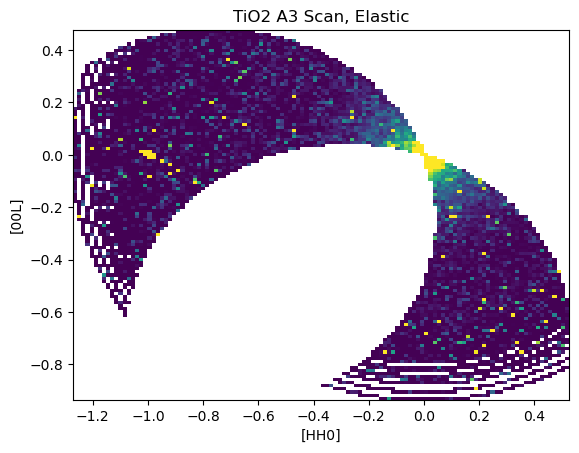

In [15]:
testobj.data.load_data_matrix_from_csv('_tio2_a3scan_cube_dataMatrix.csv')
testobj.data.write_data_to_ng0('tio2_a3scan_cube.ng0')


import matplotlib.pyplot as plt
testobj.data.project_data_QE()
U,V,I = testobj.data.bin_constE_slice(120,120,[-2,2],[-2,2],[-1,1])

plt.figure()
plt.pcolormesh(U,V,I.T,vmin=0,vmax=20)
plt.xlabel('[HH0]')
plt.ylabel('[00L]')
plt.title("TiO2 A3 Scan, Elastic")

## It is also simple to emulate an experimental scan using the same values of A3, kidney angle, Ei, and Ef. Parameters are copied directly from ng0 file.

In [16]:
testobj.data.data_matrix=False 
#object looks for previous scans in the data matrix, set the data matrix to False to disable this behavior and run 
# all scans regardless of if they have been run before.
sample_ng0 = 'Example_ng0_files/fpx78891.ng0'
testobj.n_sample=1e6
testobj.simulate_ng0(sample_ng0,n_threads=12)



/dev/shm/memory successfully mounted.
Emulating scan from fpx78891.ng0


INFO: Using directory: "Ei_5.0_beta1_1.01646_beta2_2.3076_n_100000000.0_sample_diam_0.02"
INFO: Using existing c-file: ./MACS_monochromator.c
INFO: Using existing binary: ./MACS_monochromator.out
INFO: ===
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has ent

Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warni

Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warning: neutron has entered guide, but can not exit !
Guide_gravity_MACS: warni

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_fpx78891png0_kidney_angle_m19p1362_Ei_5p0000_Ef_4p9976_A3_angle_m41p4675_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_fpx78891png0_kidney_angle_m19p1362_Ei_5p0000_Ef_4p9976_A3_angle_m42p2676_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_fpx78891png0_kidney_angle_m19p1362_Ei_5p0000_Ef_4p9976_A3_angle_m40p6672_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_fpx78891png0_kidney_angle_m19p1362_Ei_5p0000_Ef_4p9976_A3_angle_m42p8672_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_fpx78891png0_kidney_angle_m19p1362_Ei_5p0000_Ef_4p9976_A3_angle_m40p4675_sample_diame

1

## We can also do this for a directory of ng0 files, this will take a while. 

In [17]:
ngo_dir = 'Example_ng0_files/'
testobj.simulate_ng0dir(ngo_dir,n_threads=12) #Uncomment this line to run the example directory.

/dev/shm/memory successfully mounted.


Ng0 Files:   0%|          | 0/17 [00:00<?, ?it/s]

Monochromator List to simulate:
Ei=5.0, Ef=4.99757, beta1=1.01646, beta2=2.3076
Emulating scan from fpx78896.ng0
Emulating scan from fpx78899.ng0
Emulating scan from fpx78891.ng0
Emulating scan from fpx78893.ng0
Emulating scan from fpx78901.ng0
Emulating scan from fpx78888.ng0
Emulating scan from fpx78898.ng0
Emulating scan from fpx78894.ng0
Emulating scan from fpx78902.ng0
Emulating scan from fpx78903.ng0
Emulating scan from fpx78892.ng0
Emulating scan from fpx78887.ng0
Found previous identical kidney simulation. If this is a mistake, 
delete the scan from the data matrix and try again. 
/dev/shm/memory/test_experiment_fpx78887png0_kidney_angle_m19p1362_Ei_5p0000_Ef_4p9976_A3_angle_m43p0676_sample_diameter_d_0p0200
Found previous identical kidney simulation. If this is a mistake, 
delete the scan from the data matrix and try again. 
/dev/shm/memory/test_experiment_fpx78887png0_kidney_angle_m19p1362_Ei_5p0000_Ef_4p9976_A3_angle_m42p8672_sample_diameter_d_0p0200
Found previous identical

INFO: Using directory: "/dev/shm/memory/test_experiment_fpx78887png0_kidney_angle_m14p7691_Ei_5p0000_Ef_4p9976_A3_angle_m37p8293_sample_diameter_d_0p0200"
Traceback (most recent call last):
  File "/usr/share/mcstas/3.3/bin/../tools/Python/mcrun/mcrun.py", line 470, in <module>
INFO: Using directory: "/dev/shm/memory/test_experiment_fpx78887png0_kidney_angle_m18p0140_Ei_5p0000_Ef_4p9976_A3_angle_m41p7734_sample_diameter_d_0p0200"
    main()
  File "/usr/share/mcstas/3.3/bin/../tools/Python/mcrun/mcrun.py", line 383, in main
INFO: Using existing c-file: ./MACS_sample_kidney.c
    mcstas = McStas(options.instr)
  File "/usr/share/mcstas/3.3/tools/Python/mcrun/mccode.py", line 92, in __init__
INFO: Using existing binary: ./MACS_sample_kidney.out
    raise IOError('No such instrument file: "%s"' % instrument_file)
OSError: No such instrument file: "MACS_sample_kidney.instr"
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_fpx78887png0_kidney_angle_m18p5834_Ei_5p0000_Ef_4p9

INFO: Using directory: "/dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m14p7691_Ei_5p0000_Ef_4p9976_A3_angle_m37p6291_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m18p5834_Ei_5p0000_Ef_4p9976_A3_angle_m42p2171_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m20p8665_Ei_5p0000_Ef_4p9976_A3_angle_m44p8001_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m17p4557_Ei_5p0000_Ef_4p9976_A3_angle_m40p9177_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./M

INFO: Using directory: "/dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m17p4557_Ei_5p0000_Ef_4p9976_A3_angle_m40p5178_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m18p0140_Ei_5p0000_Ef_4p9976_A3_angle_m41p5732_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m20p8665_Ei_5p0000_Ef_4p9976_A3_angle_m44p6002_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m18p0140_Ei_5p0000_Ef_4p9976_A3_angle_m41p3735_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset 

INFO: Using directory: "/dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m16p9030_Ei_5p0000_Ef_4p9976_A3_angle_m39p8598_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m18p5834_Ei_5p0000_Ef_4p9976_A3_angle_m41p8174_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m18p5834_Ei_5p0000_Ef_4p9976_A3_angle_m41p6172_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m12p7294_Ei_5p0000_Ef_4p9976_A3_angle_m34p7677_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_fpx78895pn

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m15p2888_Ei_5p0000_Ef_4p9976_A3_angle_m37p6853_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m15p2888_Ei_5p0000_Ef_4p9976_A3_angle_m37p4853_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m18p0140_Ei_5p0000_Ef_4p9976_A3_angle_m40p9733_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m18p0140_Ei_5p0000_Ef_4p9976_A3_angle_m40p7731_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset 

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m18p5834_Ei_5p0000_Ef_4p9976_A3_angle_m41p2171_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m18p5834_Ei_5p0000_Ef_4p9976_A3_angle_m41p0171_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m12p7294_Ei_5p0000_Ef_4p9976_A3_angle_m34p1679_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m12p7294_Ei_5p0000_Ef_4p9976_A3_angle_m33p9679_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset 

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m13p2324_Ei_5p0000_Ef_4p9976_A3_angle_m34p4385_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m13p2324_Ei_5p0000_Ef_4p9976_A3_angle_m34p2385_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m15p2888_Ei_5p0000_Ef_4p9976_A3_angle_m37p0847_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m15p2888_Ei_5p0000_Ef_4p9976_A3_angle_m36p8850_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset 

INFO: Using directory: "/dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m13p7355_Ei_5p0000_Ef_4p9976_A3_angle_m34p7006_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m16p3557_Ei_5p0000_Ef_4p9976_A3_angle_m37p8001_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m16p3557_Ei_5p0000_Ef_4p9976_A3_angle_m37p5999_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m18p5834_Ei_5p0000_Ef_4p9976_A3_angle_m40p6172_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_fpx78895pn

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m13p2324_Ei_5p0000_Ef_4p9976_A3_angle_m33p8386_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m13p2324_Ei_5p0000_Ef_4p9976_A3_angle_m33p6384_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m12p7294_Ei_5p0000_Ef_4p9976_A3_angle_m33p3678_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m12p7294_Ei_5p0000_Ef_4p9976_A3_angle_m33p1679_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset 

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m13p7355_Ei_5p0000_Ef_4p9976_A3_angle_m34p3007_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m13p7355_Ei_5p0000_Ef_4p9976_A3_angle_m34p1005_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m18p0140_Ei_5p0000_Ef_4p9976_A3_angle_m39p5730_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m18p0140_Ei_5p0000_Ef_4p9976_A3_angle_m39p3732_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset 

INFO: Using directory: "/dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m21p4746_Ei_5p0000_Ef_4p9976_A3_angle_m42p8425_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m14p7691_Ei_5p0000_Ef_4p9976_A3_angle_m35p0292_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m14p7691_Ei_5p0000_Ef_4p9976_A3_angle_m34p8293_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m16p9030_Ei_5p0000_Ef_4p9976_A3_angle_m37p8600_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset 

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m15p2888_Ei_5p0000_Ef_4p9976_A3_angle_m35p2849_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m15p2888_Ei_5p0000_Ef_4p9976_A3_angle_m35p0850_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m12p7294_Ei_5p0000_Ef_4p9976_A3_angle_m32p5678_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m12p7294_Ei_5p0000_Ef_4p9976_A3_angle_m32p3678_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset 

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m17p4557_Ei_5p0000_Ef_4p9976_A3_angle_m37p7180_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m17p4557_Ei_5p0000_Ef_4p9976_A3_angle_m37p5178_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m16p3557_Ei_5p0000_Ef_4p9976_A3_angle_m36p1997_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m21p4746_Ei_5p0000_Ef_4p9976_A3_angle_m42p4426_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m16p3557_Ei_5p0000_Ef_4p9976_A3_angle_m35p9998_sample_diame

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m12p7294_Ei_5p0000_Ef_4p9976_A3_angle_m31p9679_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m20p8665_Ei_5p0000_Ef_4p9976_A3_angle_m41p6002_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m12p7294_Ei_5p0000_Ef_4p9976_A3_angle_m31p7677_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m20p8665_Ei_5p0000_Ef_4p9976_A3_angle_m41p4002_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset 

Emulating scan from fpx78897.ng0


INFO: Using directory: "/dev/shm/memory/test_experiment_fpx78897png0_kidney_angle_m15p8194_Ei_5p0000_Ef_4p9976_A3_angle_m39p1440_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_fpx78897png0_kidney_angle_m13p7355_Ei_5p0000_Ef_4p9976_A3_angle_m32p9006_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m17p4557_Ei_5p0000_Ef_4p9976_A3_angle_m37p3179_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m16p3557_Ei_5p0000_Ef_4p9976_A3_angle_m35p7998_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_fpx78897pn

Emulating scan from fpx78900.ng0


INFO: Using directory: "/dev/shm/memory/test_experiment_fpx78900png0_kidney_angle_m14p2495_Ei_5p0000_Ef_4p9976_A3_angle_m37p1664_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m14p7691_Ei_5p0000_Ef_4p9976_A3_angle_m34p0295_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_fpx78900png0_kidney_angle_m14p7691_Ei_5p0000_Ef_4p9976_A3_angle_m33p8293_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m21p4746_Ei_5p0000_Ef_4p9976_A3_angle_m42p0425_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset 

Emulating scan from fpx78889.ng0


INFO: Using directory: "/dev/shm/memory/test_experiment_fpx78889png0_kidney_angle_m20p2970_Ei_5p0000_Ef_4p9976_A3_angle_m44p3706_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_fpx78895png0_kidney_angle_m13p2324_Ei_5p0000_Ef_4p9976_A3_angle_m32p2388_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_fpx78889png0_kidney_angle_m13p2324_Ei_5p0000_Ef_4p9976_A3_angle_m32p0386_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_fpx78897png0_kidney_angle_m15p8194_Ei_5p0000_Ef_4p9976_A3_angle_m39p1440_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset 

Emulating scan from fpx78890.ng0


INFO: Using directory: "/dev/shm/memory/test_experiment_fpx78890png0_kidney_angle_m19p7055_Ei_5p0000_Ef_4p9976_A3_angle_m43p7117_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_fpx78900png0_kidney_angle_m16p9030_Ei_5p0000_Ef_4p9976_A3_angle_m36p4601_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_fpx78897png0_kidney_angle_m13p7355_Ei_5p0000_Ef_4p9976_A3_angle_m32p9006_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_fpx78890png0_kidney_angle_m13p7355_Ei_5p0000_Ef_4p9976_A3_angle_m32p7008_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset 

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_fpx78890png0_kidney_angle_m19p7055_Ei_5p0000_Ef_4p9976_A3_angle_m43p5115_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_fpx78890png0_kidney_angle_m13p7355_Ei_5p0000_Ef_4p9976_A3_angle_m32p5007_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_fpx78890png0_kidney_angle_m15p8194_Ei_5p0000_Ef_4p9976_A3_angle_m38p5434_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_fpx78890png0_kidney_angle_m19p7055_Ei_5p0000_Ef_4p9976_A3_angle_m43p3116_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_fpx78890png0_kidney_angle_m15p8194_Ei_5p0000_Ef_4p9976_A3_angle_m38p3439_sample_diame

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_fpx78890png0_kidney_angle_m14p2495_Ei_5p0000_Ef_4p9976_A3_angle_m35p7662_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_fpx78890png0_kidney_angle_m19p7055_Ei_5p0000_Ef_4p9976_A3_angle_m42p7117_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_fpx78890png0_kidney_angle_m14p2495_Ei_5p0000_Ef_4p9976_A3_angle_m35p5665_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Using directory: "/dev/shm/memory/test_experiment_fpx78890png0_kidney_angle_m19p7055_Ei_5p0000_Ef_4p9976_A3_angle_m42p5115_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset 

INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_fpx78890png0_kidney_angle_m19p7055_Ei_5p0000_Ef_4p9976_A3_angle_m41p9119_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_fpx78890png0_kidney_angle_m19p7055_Ei_5p0000_Ef_4p9976_A3_angle_m41p7117_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_fpx78890png0_kidney_angle_m14p2495_Ei_5p0000_Ef_4p9976_A3_angle_m34p7665_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_fpx78890png0_kidney_angle_m15p8194_Ei_5p0000_Ef_4p9976_A3_angle_m36p5436_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_fpx78890png0_kidney_angle_m14p2495_Ei_5p0000_Ef_4p9976_A3_angle_m34p5665_sample_diame

INFO: Using directory: "/dev/shm/memory/test_experiment_fpx78890png0_kidney_angle_m19p7055_Ei_5p0000_Ef_4p9976_A3_angle_m40p9119_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_fpx78890png0_kidney_angle_m20p2970_Ei_5p0000_Ef_4p9976_A3_angle_m41p5708_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_fpx78890png0_kidney_angle_m20p2970_Ei_5p0000_Ef_4p9976_A3_angle_m41p3704_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_fpx78890png0_kidney_angle_m15p8194_Ei_5p0000_Ef_4p9976_A3_angle_m35p5434_sample_diameter_d_0p0200
INFO: Using directory: "/dev/shm/memory/test_experiment_fpx78890pn

INFO: Using directory: "/dev/shm/memory/test_experiment_fpx78890png0_kidney_angle_m19p7055_Ei_5p0000_Ef_4p9976_A3_angle_m39p7117_sample_diameter_d_0p0200"
INFO: Using existing c-file: ./MACS_sample_kidney.c
INFO: Using existing binary: ./MACS_sample_kidney.out
INFO: ===
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_fpx78890png0_kidney_angle_m20p2970_Ei_5p0000_Ef_4p9976_A3_angle_m40p3704_sample_diameter_d_0p0200
INFO: Placing instr file copy MACS_sample_kidney.instr in dataset /dev/shm/memory/test_experiment_fpx78890png0_kidney_angle_m19p7055_Ei_5p0000_Ef_4p9976_A3_angle_m39p7117_sample_diameter_d_0p0200


1

## At any point the files in the kidney scan folder can be converted into MSlice readable ng0 files. 
The files may be divided into individual Ei values or combined into a single larger one. If they originate from ng0 files, they may also be individual ng0 files corresponding to their origin files

In [18]:
#Here we combine any scans that exist individually and append them to the data holder class
testobj.data.combine_csv_scans(preserve_old=True,flagstr='_combined_')
testobj.data.load_data_matrix_from_csv(csv_name='_combined_dataMatrix.csv')

ValueError: No objects to concatenate

In [ ]:
#The data is now written to a MACS style file for comparison in MSlice.
testobj.data.write_data_to_ng0(filename='_cube_TiO2_demonstration_scan.ng0',beta_1=testobj.monochromator.beta_1,\
                               beta_2=testobj.monochromator.beta_2)

In [ ]:
testobj.data.combine_all_csv()
testobj.data.load_data_matrix_from_csv('_total.csv')

In [ ]:
testobj.data.write_data_to_ng0(filename='_a3scan.ng0')